# Prices EDA

In this Notebook, we're going to examine how time-series data is constructed and distributed. We know that gas stations in Germany are required to report any change in their petrol prices in (almost) real-time. This means that data isn't generated centrally but is decentralized across approximately 16,000 instances. We observe that the API creates some batched timestamps rather than a single timestamp for every observed price change, but this doesn't provide much help. We encounter three main issues with the data:

* It's not uniformly sampled, which means that not every timestamp represents each gas station. In fact, each timestamp includes only a relatively small number of price changes, although more than one.
* Timestamps aren't equidistant, which is to be expected as gas stations can change their prices at will and at any time. Sometimes prices change 10 times per hour, and sometimes only once a day.
* In addition to the irregular time-scale, there's no rule dictating when gas stations sell gas. They might be closed for an entire day, have varying opening hours, or never close at all. They might also run out of product and stop selling entirely.

We're trying to investigate the details of the outlined problems and find solutions to pre-process our data for a baseline model. Note that there are models capable of handling irregular data. We will explore these further down the line. However, in a first step, our goal is to resample the data as efficiently as possible and create a regular panel. To do this, we need to:

* Find reasonable time-bins for the report. If we make these too granular, the dataset will bloat exponentially, making it computationally unreasonable.
* If the bins are too large, we lose too much information. Our goal is to observe and predict impulse responses from neighboring gas stations. Large bins would falsely imply that events are happening simultaneously, which they aren't, as the data generation process (DGP) is decentralized.
* This process will create many sparse tables, which will need to be filled with the current prices of each gas station at each timestamp. These prices correspond to the last price the respective station set.

Especially the last point is quite unfortunate but necessary for classical models or "simpler" ML models to handle the data. However, it doesn't really add any information that wasn't in the original dataset, yet it needs to be computed. Our goal is to find a model that can handle this irregular data without the need for resampling. One way to tackle this could be the creation of time distances as features, which we will also investigate in this notebook.

In [6]:
import pandas as pd
import numpy as np
import datetime as dt
import random
import pyarrow

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from src.config.paths import ROOT_DIR, SAMPLE_DIR, PRICES_DIR

import src.fileutils as files
import src.visualization as viz
import src.process as process
from src.process_files import PriceProcessor

In [7]:
stations_info_file = ROOT_DIR / 'data' / 'stations.csv'

RSEED = 42
random.seed(RSEED)
np.random.seed(RSEED)

In [12]:
raw_prices = PriceProcessor(PRICES_DIR, SAMPLE_DIR)
raw_prices.get_sample(random_state=RSEED).head(5)


,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
0,2021-08-09 00:01:07+02,00299b2b-4fcf-454a-9dfd-871a57bfe4ff,1.349,1.589,1.529,1,1,1
1,2021-08-09 00:01:07+02,65b83b5f-f0c5-4db0-8be1-e111cd066276,1.349,1.589,1.529,1,1,1
2,2021-08-09 00:01:07+02,3e8b54ba-efd2-48ea-b948-7104f540d930,1.429,1.659,1.599,1,0,0
3,2021-08-09 00:01:07+02,dfc32f99-aa65-4fd4-b16e-a2cc53f9be15,1.429,1.669,1.609,1,1,1
4,2021-08-09 00:01:07+02,a1af2da1-8095-43ff-9640-7c0260c00048,1.419,1.609,0.000,1,0,0


## Initial EDA and cleaning

But let's first take a step back and start with some basic EDA by importing a random day from our data.

In [15]:
# prices_sample = pd.read_csv(files.pick_random_csv(PRICES_DIR, random_state=RSEED))
prices_sample = raw_prices.sample

display(prices_sample.sample(3, random_state=RSEED))
display(viz.nice_summary(prices_sample))

,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
195420,2021-08-09 15:34:06+02,c83474cf-5736-43eb-adc5-91ccb28bb5e8,1.359,1.599,1.539,3,3,3
78104,2021-08-09 10:11:06+02,001e3111-58c3-4e99-b6d5-a8f244b579f3,1.449,1.659,1.599,0,1,1
269760,2021-08-09 18:34:08+02,9b7b1b32-4532-4e99-8b29-9edb64d44a0a,1.359,1.599,1.539,0,1,1


,Columns,Dtype,nunique,Non-Null Count,Missing,Missing %,Zero Count,mean,std,min,25%,50%,75%,max
0,date,object,1257,331244,-,-,0,-,-,-,-,-,-,-
1,station_uuid,object,14999,331244,-,-,0,-,-,-,-,-,-,-
2,diesel,float64,181,331244,-,-,33,1.39,0.05,-0.0,1.36,1.39,1.42,2.0
3,e5,float64,181,331244,-,-,4769,1.6,0.2,-0.0,1.59,1.62,1.65,2.07
4,e10,float64,176,331244,-,-,14572,1.49,0.32,-0.0,1.53,1.56,1.59,2.03
5,dieselchange,int64,4,331244,-,-,65371,0.89,0.61,0.0,1.0,1.0,1.0,3.0
6,e5change,int64,4,331244,-,-,67445,0.89,0.61,0.0,1.0,1.0,1.0,3.0
7,e10change,int64,4,331244,-,-,75399,0.86,0.61,0.0,1.0,1.0,1.0,3.0


* During August 9th 2021, a total of 331,244 price changes have been reported. As we can see from the sample, multiple prices can be changed at the same time.
* The API batched this into 1257 different timestamps for that day.
* 14,999 gas stations reported their prices that day.
* The range of different prices is limited to aprox. 181 variations. We should look at how they are distributed across the board.
* Luckily, there are no missing values per se, but there are zero values that require investigation
* Apparently, not all gas stations sell all types of fuel. Especially e10 but also e5 has been reported with no price on many occurrences.
* So far we can tell nothing about prices being withdrawn (*change==2) or newly added (*change==3).

The last point is a potential source of corrupted data, which is why we investigate this first before looking at the qualitative aspects of the data.

### Price withdrawals and new prices

In [16]:
# Transforming the 'date' column into datetime and setting it as index
prices_sample = process.set_panel_index(prices_sample, individual='station_uuid', names=['date','station'])
    
# Since we have very irregular timestamps and duplicate timestamp indices, a series of unique timestamps will also be handy    
timestamps = process.get_unique_timestamps(prices_sample)
        
# Filter for all reports with 'new' or 'removed' prices
remove_new = prices_sample.query('dieselchange in [2,3] or e5change in [2,3] or e10change in [2,3]')

display(remove_new.head(5))
display(remove_new.tail(5))
print(
    'Out of {} reports a total of {} are flagged as new entries or price removals, '
    'which accounts for {:.2f}% of the reports.' \
    .format(
        len(prices_sample),
        len(remove_new),
        100 * len(remove_new)/len(prices_sample),
    )
)


,,diesel,e5,e10,dieselchange,e5change,e10change
date,station,,,,,,
2021-08-09 05:43:07+02:00,21656c59-4297-4655-9f8b-dc8bffac6ace,1.429,0.000,1.649,0,2,0
2021-08-09 05:45:06+02:00,21656c59-4297-4655-9f8b-dc8bffac6ace,1.449,1.729,1.669,1,3,1
2021-08-09 06:03:11+02:00,19155bd4-022b-424b-a62f-882d89c6d709,1.409,1.649,1.629,3,3,3
2021-08-09 06:47:07+02:00,21656c59-4297-4655-9f8b-dc8bffac6ace,1.429,0.000,1.649,0,2,0
2021-08-09 06:49:09+02:00,21656c59-4297-4655-9f8b-dc8bffac6ace,1.459,1.759,1.699,1,3,1


,,diesel,e5,e10,dieselchange,e5change,e10change
date,station,,,,,,
2021-08-09 20:26:06+02:00,5fb44aa1-45d9-4332-9945-29d9b09c16f3,1.319,1.519,1.499,3,3,3
2021-08-09 20:53:07+02:00,21656c59-4297-4655-9f8b-dc8bffac6ace,1.399,1.659,1.599,1,3,1
2021-08-09 22:17:07+02:00,02e8c37e-28fa-4755-a718-e91f345e85f5,0.000,1.549,0.000,2,1,0
2021-08-09 22:47:06+02:00,21656c59-4297-4655-9f8b-dc8bffac6ace,1.399,0.000,1.599,0,2,0
2021-08-09 22:51:06+02:00,21656c59-4297-4655-9f8b-dc8bffac6ace,1.429,1.689,1.629,1,3,1


Out of 331244 reports a total of 15044 are flagged as new entries or price removals, which accounts for 4.54% of the reports.


This sample of the first 5 entries already shows that there are some gas stations in distress with their technical abilities. They do not actually withdraw their prices but instead remove them only to post new prices a few moments later. This does indeed indicate corrupt data as it's merely a price change withe extra steps. The first intuition is: If there's a price removal in t and a new price in t+1 then this was in fact a price change in t. But let's first look a bit more into this.

In [17]:
# Number of stations, number of stations that had a irregular price change
num_stations = prices_sample.index.get_level_values('station').nunique()
num_stations_rn = remove_new.index.get_level_values('station').nunique()

# Slice of all stations that have more than one removed or new entry
duplicated_rn = remove_new[remove_new.index.get_level_values('station').duplicated(False) == True]

print(
    'Total number of operating gas stations on this day: {}\n'
    'Number of reports with at least one new or removed price: {}\n'
    'Number of operating gas stations with new or removed prices: {}\n'
    'Number of those with more than one entry: {}\n'
    'accounting for {} extra new or removed entries.\n'
    .format(
        num_stations,
        len(remove_new),
        num_stations_rn,
        duplicated_rn.index.get_level_values('station').nunique(),~
        len(duplicated_rn),
    )
)

Total number of operating gas stations on this day: 14999
Number of reports with at least one new or removed price: 15044
Number of operating gas stations with new or removed prices: 14984
Number of those with more than one entry: 20
accounting for -81 extra new or removed entries.



### Stations with only a singular 'new price' (pricechange==3)
Let's first have a look at the majority of these reports, stations with only one entry of new or removed prices. We already know that almost all stations have new entries during that day.

In [18]:
# All stations which have only 1 entry with new or removed prices, a list of their timestamps and the slice of the original price table at these particular timestamps
rn = remove_new[~remove_new.index.get_level_values('station').duplicated(False) == True]
rn_timestamps = rn.index.get_level_values('date').unique()
rn_df = prices_sample.loc[rn_timestamps]

In [19]:
# All stations which have only 1 entry with new or removed prices, a list of their timestamps and the slice of the original price table at these particular timestamps
rn = remove_new[~remove_new.index.get_level_values('station').duplicated(False) == True]
rn_timestamps = rn.index.get_level_values('date').unique()
rn_df = prices_sample.loc[rn_timestamps]


# Oddly, these all happen at the exact same moment
print(f'Timestamps with new entries during the sample day:\n {rn_timestamps}')
print(f'Number of entries at the unique timespamps: {len(rn_df)}')
display(pd.concat([rn.head(2),rn.tail(2)]))

# And just to doublecheck, lets look if any of the entries on these particular timestamps are 'regular', i.e. have 1 or 0 entries
display(rn_df.query('~(dieselchange in [2,3] or e5change in [2,3] or e10change in [2,3])'))

Timestamps with new entries during the sample day:
 DatetimeIndex(['2021-08-09 15:34:06+02:00'], dtype='datetime64[ns, Europe/Berlin]', name='date', freq=None)
Number of entries at the unique timespamps: 14984


diesel     e5   
date                      station                                               
2021-08-09 15:34:06+02:00 a1e15688-663a-42da-86b3-0501597bcab7   1.338  1.538  \
                          60b27274-457a-4e44-a767-afd7ca5159c6   1.449  1.679   
                          4817c6f7-4629-4e7b-b554-66b25734c6e5   1.409  1.659   
                          33fd28b3-dbf7-48e8-9b9b-961ffc801e0e   1.439  1.669   

                                                                  e10   
date                      station                                       
2021-08-09 15:34:06+02:00 a1e15688-663a-42da-86b3-0501597bcab7  1.478  \
                          60b27274-457a-4e44-a767-afd7ca5159c6  1.619   
                          4817c6f7-4629-4e7b-b554-66b25734c6e5  1.599   
                          33fd28b3-dbf7-48e8-9b9b-961ffc801e0e  1.609   

                                                                dieselchange   
date                      station                                              
2021-08-09 15:34:06+02:00 a1e15688-663a-42da-86b3-0501597bcab7             3  \
                          60b27274-457a-4e44-a767-afd7ca5159c6             3   
                          4817c6f7-4629-4e7b-b554-66b25734c6e5             3   
                          33fd28b3-dbf7-48e8-9b9b-961ffc801e0e             3   

                                                                e5change   
date                      station                                          
2021-08-09 15:34:06+02:00 a1e15688-663a-42da-86b3-0501597bcab7         3  \
                          60b27274-457a-4e44-a767-afd7ca5159c6         3   
                          4817c6f7-4629-4e7b-b554-66b25734c6e5         3   
                          33fd28b3-dbf7-48e8-9b9b-961ffc801e0e         3   

                                                                e10change  
date                      station                                          
2021-08-09 15:34:06+02:00 a1e15688-663a-42da-86b3-0501597bcab7          3  
                          60b27274-457a-4e44-a767-afd7ca5159c6          3  
                          4817c6f7-4629-4e7b-b554-66b25734c6e5          3  
                          33fd28b3-dbf7-48e8-9b9b-961ffc801e0e          3

,,diesel,e5,e10,dieselchange,e5change,e10change
date,station,,,,,,


In [20]:
tdelta = pd.Timedelta(seconds=1)

# Reduce the dataframe to individual stations and take the last 
prices_sample[:(rn_timestamps[0] - tdelta)]

diesel     e5   
date                      station                                               
2021-08-09 00:01:07+02:00 00299b2b-4fcf-454a-9dfd-871a57bfe4ff   1.349  1.589  \
                          65b83b5f-f0c5-4db0-8be1-e111cd066276   1.349  1.589   
                          3e8b54ba-efd2-48ea-b948-7104f540d930   1.429  1.659   
                          dfc32f99-aa65-4fd4-b16e-a2cc53f9be15   1.429  1.669   
                          a1af2da1-8095-43ff-9640-7c0260c00048   1.419  1.609   
...                                                                ...    ...   
2021-08-09 15:19:07+02:00 6f5f00c9-f3d2-11e9-b0e4-005056a2a083   1.389  1.619   
                          cee68a1d-ce96-4678-8e05-9dc9a6787b62   1.319  1.599   
                          c5fb7246-27b8-4c63-9d87-16f9d6cbc493   1.359  1.569   
                          719d9a55-0451-11ea-b951-005056a2a083   1.339  1.559   
                          5c04404e-1cef-11eb-9fcb-005056a2a083   1.349  1.589   

                                                                  e10   
date                      station                                       
2021-08-09 00:01:07+02:00 00299b2b-4fcf-454a-9dfd-871a57bfe4ff  1.529  \
                          65b83b5f-f0c5-4db0-8be1-e111cd066276  1.529   
                          3e8b54ba-efd2-48ea-b948-7104f540d930  1.599   
                          dfc32f99-aa65-4fd4-b16e-a2cc53f9be15  1.609   
                          a1af2da1-8095-43ff-9640-7c0260c00048  0.000   
...                                                               ...   
2021-08-09 15:19:07+02:00 6f5f00c9-f3d2-11e9-b0e4-005056a2a083  1.559   
                          cee68a1d-ce96-4678-8e05-9dc9a6787b62  1.539   
                          c5fb7246-27b8-4c63-9d87-16f9d6cbc493  1.519   
                          719d9a55-0451-11ea-b951-005056a2a083  1.499   
                          5c04404e-1cef-11eb-9fcb-005056a2a083  1.529   

                                                                dieselchange   
date                      station                                              
2021-08-09 00:01:07+02:00 00299b2b-4fcf-454a-9dfd-871a57bfe4ff             1  \
                          65b83b5f-f0c5-4db0-8be1-e111cd066276             1   
                          3e8b54ba-efd2-48ea-b948-7104f540d930             1   
                          dfc32f99-aa65-4fd4-b16e-a2cc53f9be15             1   
                          a1af2da1-8095-43ff-9640-7c0260c00048             1   
...                                                                      ...   
2021-08-09 15:19:07+02:00 6f5f00c9-f3d2-11e9-b0e4-005056a2a083             1   
                          cee68a1d-ce96-4678-8e05-9dc9a6787b62             0   
                          c5fb7246-27b8-4c63-9d87-16f9d6cbc493             0   
                          719d9a55-0451-11ea-b951-005056a2a083             1   
                          5c04404e-1cef-11eb-9fcb-005056a2a083             1   

                                                                e5change   
date                      station                                          
2021-08-09 00:01:07+02:00 00299b2b-4fcf-454a-9dfd-871a57bfe4ff         1  \
                          65b83b5f-f0c5-4db0-8be1-e111cd066276         1   
                          3e8b54ba-efd2-48ea-b948-7104f540d930         0   
                          dfc32f99-aa65-4fd4-b16e-a2cc53f9be15         1   
                          a1af2da1-8095-43ff-9640-7c0260c00048         0   
...                                                                  ...   
2021-08-09 15:19:07+02:00 6f5f00c9-f3d2-11e9-b0e4-005056a2a083         1   
                          cee68a1d-ce96-4678-8e05-9dc9a6787b62         1   
                          c5fb7246-27b8-4c63-9d87-16f9d6cbc493         1   
                          719d9a55-0451-11ea-b951-005056a2a083         0   
                          5c04404e-1cef-11eb-9fcb-005056a2a083         1   

                              

It indeed looks like there was a system-wide price-prompt. The entire timestamp is labeled as new prices. There are two things of interest now:
* Are these prices any different to the prices recorded before the prompt? What were the last prices at the timestamp immediately before but also for each singular station
* Are there any stations in the table that weren't prompted

In [21]:
# Get all the previous timestamps to the timestamps that had removed or new values where stations occurred only once
preceded_t = timestamps.shift(1).loc[rn_timestamps]
preceded = prices_sample.loc[preceded_t]

print(f'Number of reports in the timestamp immediately before the mass-prompt: {len(preceded)} at timestamp {preceded.index.unique()[0]}')

Number of reports in the timestamp immediately before the mass-prompt: 244 at timestamp (Timestamp('2021-08-09 15:19:07+0200', tz='Europe/Berlin'), '1b52f84f-03cc-457c-bf76-dcbe5fd3eb33')


As it turns out, the timestamp before the mass-report of new values was just a regular batch of reports. Nevertheless would it be interesting to know whether there are any differences between previously reported prices from each station to the mass-report.
For that we need to create a DataFrame that contains all information up until the mass-prompt and compare it to the massprompt dataframe

In [22]:
# Create a minimal time-delta to cut off the timestamp we want to exclude, as DatetimeIndex slices are inclusive on the interval-end
tdelta = pd.Timedelta(seconds=1)

# Reduce the dataframe to individual stations and take the last 
rn_df_preceding = prices_sample[:(rn_timestamps[0] - tdelta)] \
    .groupby(level='station') \
    .tail(1) \
    .sort_index(level='date')

print(
    'Number of stations hat reported before the mass-prompt: {} \n'
    'Number of stations included in the mass-prompt: {}'
    .format(
        len(rn_df_preceding),
        len(rn_df),
    )
)


Number of stations hat reported before the mass-prompt: 14081 
Number of stations included in the mass-prompt: 14984


Now this doesn't add up, though we can easily explain it by the fact that not every operating station has to change their price every day. But what if of all the operating stations that already operated that day not all responded to the mass prompt?

In [23]:
# create Series for both lists of stations and merge them into a DataFrame to create NaN values where they do not overlap

prompt_compare = pd.concat([
    rn_df_preceding.index.get_level_values('station').to_series(name='t-1'),
    rn_df.index.get_level_values('station').to_series(name='t'),
    ], axis=1
)

# Slice of the DataFrame that was either inactive until the prompt or did not react to it
pc_nan = prompt_compare[prompt_compare.isna().any(axis=1)]
print(f"Active stations that did not react to the mass-prompt: {pc_nan['t'].isna().sum()}")
print(f"Stations that weren't active before but did react to the mass-prompt: {pc_nan['t-1'].isna().sum()}")
display(pd.concat([pc_nan.head(2),pc_nan.tail(2)]))

# Inverse slice of that, i.e. stations that were active and reacted
pc = prompt_compare[~prompt_compare.isna().any(axis=1)]
print(f"Active stations that did react to the mass-prompt: \n{pc.count()}")

Active stations that did not react to the mass-prompt: 13
Stations that weren't active before but did react to the mass-prompt: 916


,t-1,t
station,,
7170da8b-7c52-4af4-bed3-90f5c3ac3e9a,7170da8b-7c52-4af4-bed3-90f5c3ac3e9a,NaN
34347890-3a4e-4c9c-87fd-8325e0843925,34347890-3a4e-4c9c-87fd-8325e0843925,NaN
99eaeb13-893e-483e-9c26-2876d920a250,NaN,99eaeb13-893e-483e-9c26-2876d920a250
a3c05496-1f6d-4d4a-a122-8cf4b464a0c1,NaN,a3c05496-1f6d-4d4a-a122-8cf4b464a0c1


Active stations that did react to the mass-prompt: 
t-1    14068
t      14068
dtype: int64


The latter is what we can definitely compare:

In [24]:
# list of all stations to compare as they were in the prompt and reported a prise before that
diff_stations = pc.index.get_level_values('station')

# merge both tables with the prompt and before-prompt prices
merged_df = pd.merge(
    rn_df_preceding.reset_index(level=0, drop=True),
    rn_df.reset_index(level=0, drop=True),
    left_index=True, right_index=True,
    suffixes=['_preceding', '_current']
    )

# make new columns that inspect price differences for each of the three products, keep only those
merged_diffs = merged_df.assign(
        diesel_diff = lambda x: x['diesel_preceding'] != x['diesel_current'],
        e5_diff = lambda x: x['e5_preceding'] != x['e5_current'],
        e10_diff = lambda x: x['e10_preceding'] != x['e10_current'],    
    ).filter(like='diff')

# keep all rows that have differences between prompt and preceding prices
merged_diffs = merged_diffs[merged_diffs.any(axis=1)]
display(merged_diffs.head())
print(f"Stations that did change at least one of their prices between their last report and the mass-prompt: {len(merged_diffs)}")
print(f"Number of Stations checked for: {len(diff_stations)}")


,diesel_diff,e5_diff,e10_diff
station,,,
2387601d-b2a5-4660-a8a0-a101cb391b49,True,True,True
90b7110e-4054-41a4-87b6-515ab765caf9,True,False,False
7ee38718-5f86-4e15-a859-a3b9e0862cee,True,False,False
8a951f27-fa37-4040-bb48-62a376d5649e,False,True,True
6fce5ae3-c3aa-43ff-a871-01e5fb754022,True,False,False


Stations that did change at least one of their prices between their last report and the mass-prompt: 6245
Number of Stations checked for: 14068


This is actually a very substantial amount of stations that only reported a price change when the system prompted them. In the grand scale of >180,000 price changes before that and >100,000 after, it's not a lot, but given the average amount of price changes reported per timestamp, it is. Lets try to put it into perspective:

Number of changes before the mass-prompt: 186556
Amount of values that changed only when they were prompted: 6245

10 timestamps with most frequent reports:
[14984  3016  2817  1937  1686  1602  1587  1401  1369  1330]
Reports per timestamp 
mean: 263.52 
median: 187.0


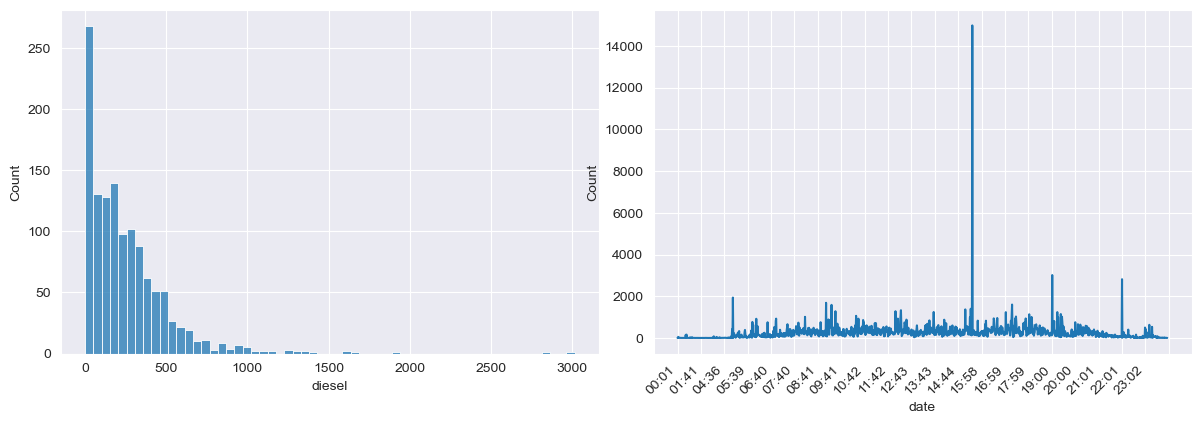

In [25]:
print(f'Number of changes before the mass-prompt: {len(prices_sample[:(rn_timestamps[0] - tdelta)])}')
print(f'Amount of values that changed only when they were prompted: {len(merged_diffs)}')

# creating a table that counts how many price changes occur at each timestamp
reports_per_timestamp = prices_sample.groupby(level='date').count().diesel.sort_values(ascending=False)
print('\n10 timestamps with most frequent reports:')
print(reports_per_timestamp.head(10).values)

print(f'Reports per timestamp \nmean: {reports_per_timestamp.mean().round(2)} \nmedian: {reports_per_timestamp.median()}')

sns.set_style('darkgrid')
figure, axis = plt.subplots(1, 2, figsize=(12, 4))
figure.tight_layout()
# excluding the 15.000 event as it's not representetive for actual price changes
sns.histplot(reports_per_timestamp[1:], ax=axis[0]);

# time-series plot of the frequency of all price-change events
counts = prices_sample.groupby(level='date').count().diesel.reset_index()
counts.date = counts.date.apply(lambda x: x.strftime('%H:%M'))
sns.lineplot(counts, x='date', y='diesel', ax=axis[1]);
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(24))

plt.show()


So, obviously, it is a massive outlier. And even if we reduced these ~15,000 changes down to only 6245 *actual* changes it would still be the biggest outlier by far, with the second biggest batch having a little over 3000 observations
> **This introduces a significant bias to a potential prediction. Unfortunately there is nothing we can really do about a data corruption like this. The performance of a prediction would just be measured against other corrupted data, as this measurement error is systemic. Gas stations are changing their prices constantly, but some of them do not report them in time Data only updates when they get prompted by the global API. The API in return attributes these measurements to a singular timestamp as it can't tell retrospectively when the price change was actually done**

We should definitely not forget about this and eventually find a solution later. What we can do for now is converting the '3's to '0's and '1's where the price didn't change and changed respectively.

### Price Removals and other new prices

We found some other instances were prices were removed and newly added. Down below you see how these might look like. The first two entries are from the same individual. A price has been removed from the list only to add a new price two minutes later. This is basically a price change that can be cleaned. Let's see if this happens more often and develop an algorithm to solve it.

In [26]:
# Let's first remove our mass prompt from the data to have a cleaner DataFrame to work on
removals_df = remove_new.drop(rn_timestamps, level='date')

# We learned from the previous section, that a new price (change==3) can be two things, a price change and an empty prompt. But what about price removals?
removals_df = removals_df.query('dieselchange==2 or e5change==2 or e10change==2')

#lets retrieve the timestamps before and after that and figure out what the stations are doing here
removals_timestamps = removals_df.index.get_level_values('date')
before_removals = timestamps.shift(1).loc[removals_timestamps]
after_removals = timestamps.shift(-1).loc[removals_timestamps]



# and reduce the dataset to the stations of interest
def get_unique_index(df, ind):
    return df.index.get_level_values(ind).unique()

def search_by_index(df, ind, list_of_indices)->pd.DataFrame:
    mask = df.index.get_level_values(ind).isin(list_of_indices)
    return df[mask]


# unique_indices = df.index.get_level_values(ind).unique()
r_stations = get_unique_index(removals_df, 'station')

prices_sample_removals = search_by_index(prices_sample, 'station', r_stations)

before = search_by_index(prices_sample_removals, 'date', before_removals)
removals = search_by_index(prices_sample_removals, 'date', removals_timestamps)
after = search_by_index(prices_sample_removals, 'date', after_removals)




In [30]:
prices_sample

diesel     e5   
date                      station                                               
2021-08-09 00:01:07+02:00 00299b2b-4fcf-454a-9dfd-871a57bfe4ff   1.349  1.589  \
                          65b83b5f-f0c5-4db0-8be1-e111cd066276   1.349  1.589   
                          3e8b54ba-efd2-48ea-b948-7104f540d930   1.429  1.659   
                          dfc32f99-aa65-4fd4-b16e-a2cc53f9be15   1.429  1.669   
                          a1af2da1-8095-43ff-9640-7c0260c00048   1.419  1.609   
...                                                                ...    ...   
2021-08-09 23:57:07+02:00 308733a3-f3a6-4259-a10a-8a8e08efa94e   1.429  0.000   
                          f059c970-6882-45ed-97c0-eb544f70b02c   1.439  1.639   
2021-08-09 23:59:08+02:00 373714ef-2e3f-4bce-96bb-676fc4a1e5df   1.339  1.589   
                          aa842438-c80d-46c1-828f-2cadb756d013   1.329  1.589   
                          57f207da-80a0-4e61-b98d-d6eef0d79cfe   1.369  1.619   

                                                                  e10   
date                      station                                       
2021-08-09 00:01:07+02:00 00299b2b-4fcf-454a-9dfd-871a57bfe4ff  1.529  \
                          65b83b5f-f0c5-4db0-8be1-e111cd066276  1.529   
                          3e8b54ba-efd2-48ea-b948-7104f540d930  1.599   
                          dfc32f99-aa65-4fd4-b16e-a2cc53f9be15  1.609   
                          a1af2da1-8095-43ff-9640-7c0260c00048  0.000   
...                                                               ...   
2021-08-09 23:57:07+02:00 308733a3-f3a6-4259-a10a-8a8e08efa94e  0.000   
                          f059c970-6882-45ed-97c0-eb544f70b02c  0.000   
2021-08-09 23:59:08+02:00 373714ef-2e3f-4bce-96bb-676fc4a1e5df  1.529   
                          aa842438-c80d-46c1-828f-2cadb756d013  1.539   
                          57f207da-80a0-4e61-b98d-d6eef0d79cfe  1.559   

                                                                dieselchange   
date                      station                                              
2021-08-09 00:01:07+02:00 00299b2b-4fcf-454a-9dfd-871a57bfe4ff             1  \
                          65b83b5f-f0c5-4db0-8be1-e111cd066276             1   
                          3e8b54ba-efd2-48ea-b948-7104f540d930             1   
                          dfc32f99-aa65-4fd4-b16e-a2cc53f9be15             1   
                          a1af2da1-8095-43ff-9640-7c0260c00048             1   
...                                                                      ...   
2021-08-09 23:57:07+02:00 308733a3-f3a6-4259-a10a-8a8e08efa94e             1   
                          f059c970-6882-45ed-97c0-eb544f70b02c             1   
2021-08-09 23:59:08+02:00 373714ef-2e3f-4bce-96bb-676fc4a1e5df             1   
                          aa842438-c80d-46c1-828f-2cadb756d013             1   
                          57f207da-80a0-4e61-b98d-d6eef0d79cfe             1   

                                                                e5change   
date                      station                                          
2021-08-09 00:01:07+02:00 00299b2b-4fcf-454a-9dfd-871a57bfe4ff         1  \
                          65b83b5f-f0c5-4db0-8be1-e111cd066276         1   
                          3e8b54ba-efd2-48ea-b948-7104f540d930         0   
                          dfc32f99-aa65-4fd4-b16e-a2cc53f9be15         1   
                          a1af2da1-8095-43ff-9640-7c0260c00048         0   
...                                                                  ...   
2021-08-09 23:57:07+02:00 308733a3-f3a6-4259-a10a-8a8e08efa94e         0   
                          f059c970-6882-45ed-97c0-eb544f70b02c         1   
2021-08-09 23:59:08+02:00 373714ef-2e3f-4bce-96bb-676fc4a1e5df         1   
                          aa842438-c80d-46c1-828f-2cadb756d013         1   
                          57f207da-80a0-4e61-b98d-d6eef0d79cfe         1   

                              

## Daily Patterns

In the following we are trying to investigate whether there are repeating daily patterns in the price changes. For that, the first thing we do is aggregate one day down to only timestamps

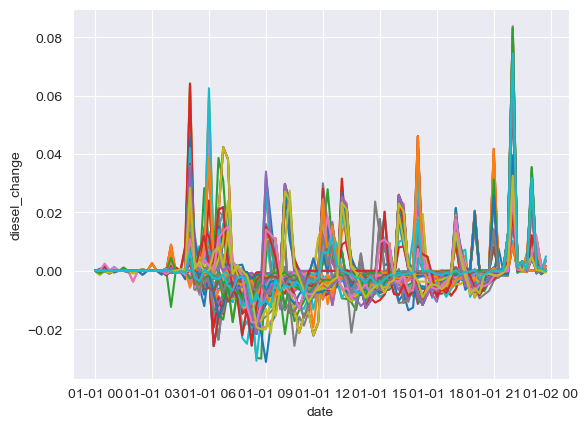

In [185]:
np.random.seed(RSEED)
# loading a subset of stations for the Düsseldorf area
dus_stations = pd.read_csv(SAMPLE_DIR / 'stations' / 'stations_dus_plus.csv')

agg_dict = {
        'diesel': 'mean',
        'e5': 'mean',
        'total_changes': 'count'
        }

def transform_method(df):
    # only keeping the timestamps and two fuels as an examples and drop all zero values
    df = process.set_datetime_index(df)
    df = df.filter(['date', 'diesel', 'e5'])
    df = df[(df>0).all(axis=1)]
    df.index = df.index.map(lambda dt: dt.replace(year=2000, month=1, day=1))
    df.index = df.index.floor('H')
    # taking the mean price across all stations for each timestamp
    df = df.groupby('date').mean()
    print(df['diesel'].iloc[0])
    return df

def resample_timestamps(prices_df: pd.DataFrame, agg_dict: dict,  date='date', individual='station', freq: str = 'H')->pd.DataFrame:
    
    # need to call this function first otherwise pd.to_datetime will bug without raising and error but can't transform days with shift in daylight saving time
    prices_df = process.set_panel_index(prices_df, date=date, individual=individual)

    #extracting the minute information before removing it from the DateTime index
    prices_df['total_changes'] = prices_df.index.get_level_values(date).minute

    # unfortunately MultiIndex DFs dont allow for direct transformation, so an ugly workaround is required to floor the DateTime index
    prices_df = prices_df.reset_index(level=date)
    prices_df[date] = prices_df[date].dt.floor(freq)
    prices_df = prices_df.set_index(date, append=True).sort_index()

    # grouping by station and freq-bins, using specified aggregation for all columns. groupby is agnostic to DataTypes so not all aggregations work on every DataType
    prices_df = prices_df.groupby([individual,date]).agg(agg_dict)

    # creating a new index-object that serves as a mask for the resampled DataFrame with equidistant timestamps
    stations = prices_df.index.get_level_values(individual).unique()
    min_date = prices_df.index.get_level_values(date).min().floor('D')
    max_date = prices_df.index.get_level_values(date).max().ceil('D') - pd.Timedelta(1, unit='us')
    date_range = pd.date_range(min_date, max_date, freq=freq)
    resampled_index = pd.MultiIndex.from_product([stations, date_range], names=[individual, date])

    # applying the resampled index to the original DataFrame and filling the NaNs.
    prices_df = prices_df.reindex(resampled_index).ffill().bfill()

    return prices_df

def my_method(df):
    df = df.filter(['date','station_uuid', 'diesel', 'e5'])
    df = df[(df[['diesel','e5']]>0).all(axis=1)]
    df = resample_timestamps(df, agg_dict, date='date', individual='station_uuid', freq='15T')
    df = df.reset_index(level=0).drop('station_uuid', axis=1)
    df = df.groupby('date').mean()
    df['diesel_change'] = df['diesel'] - df['diesel'].shift(1)
    df['e5_change'] = np.log(df['e5']) - np.log(df['e5'].shift(1))
    df = df.fillna(0)
    df.index = df.index.map(lambda dt: dt.replace(year=2000, month=1, day=1))
    return df

sample_list = []
# Creating a new couple processor objects with the subset filter and plotting them all
daily = PriceProcessor(PRICES_DIR, SAMPLE_DIR, subset=dus_stations, subset_df_column='uuid', subset_column='station_uuid')
for seed in np.random.randint(0, 101, size=100):
    daily.get_sample(random_state=seed)
    daily.set_method(my_method)
    daily.process_data(daily.sample)
    sample_list.append(daily.last_processed)
    sns.lineplot(data=daily.last_processed, x=daily.last_processed.index, y='diesel_change');

plt.show()

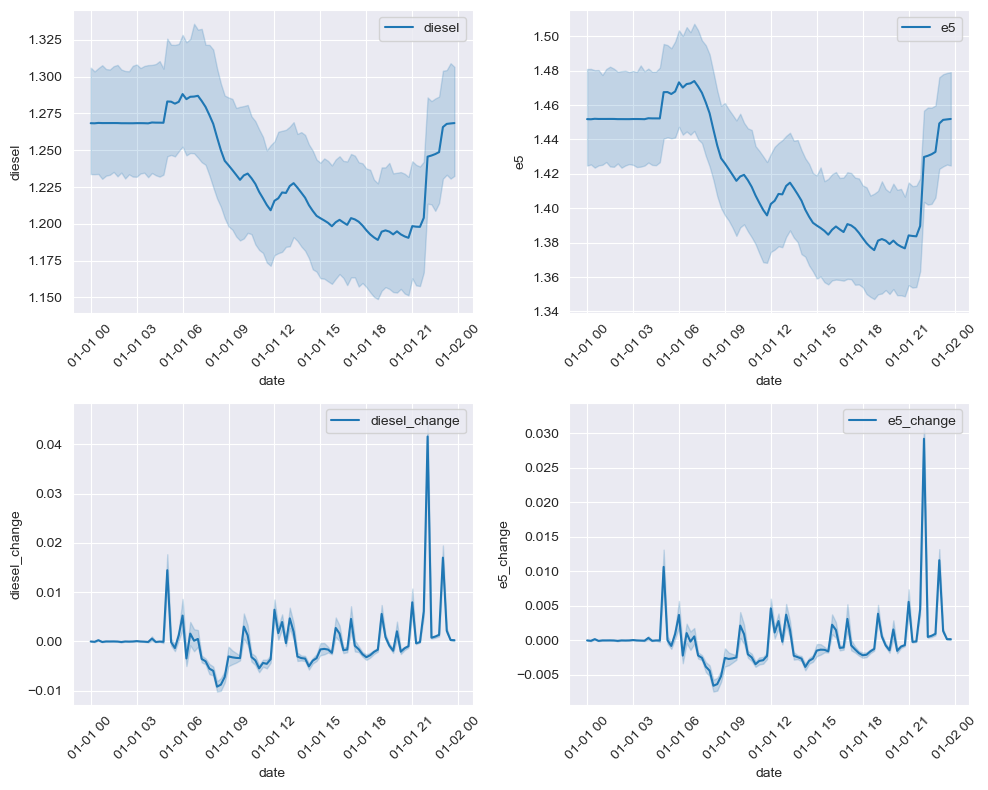

In [186]:
sample_concat = pd.concat(sample_list)
sample_concat.groupby(sample_concat.index).mean()

figure, ax = plt.subplots(2, 2, figsize=(10,8))

plots = ['diesel','e5','diesel_change','e5_change']

for i in range(2):
    for j in range(2):
        plot = plots[i*2 + j]
        sns.lineplot(data=sample_concat, x=sample_concat.index, y=plot, ax=ax[i, j]);
        ax[i, j].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability
        ax[i, j].legend([plot], loc='upper right')  # Position the legend

plt.tight_layout()
plt.show()


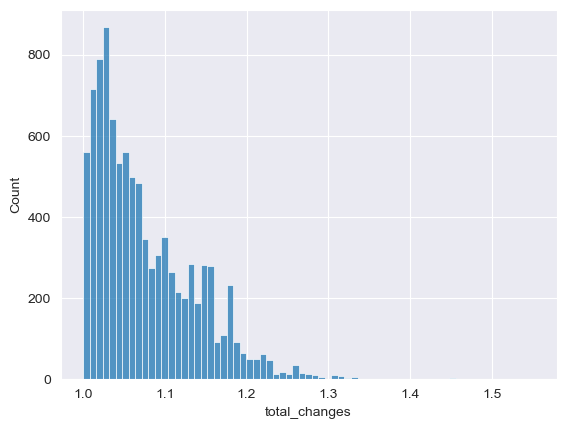

In [187]:
sns.histplot(sample_concat.total_changes);